# Multiclass Semantic Segmentation using U-Net with ResNet as the Backbone

In [3]:
import os
import cv2
import numpy as np
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
scaler = MinMaxScaler()
root_directory = './Semantic segmentation dataset'

patch_size = 256

In [5]:
# Read images from the 'images' subdirectory under each Tile (1-8)
# All the images are of different sizes.
# Option 1: RESIZE, Some images are too large and some small. Resizing will change the size of real objects.
# Option 2: CROP, cropping them to the nearest size divisible by 256 and then dividing all the images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    # print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   # Find all 'images' directories
        images = sorted(os.listdir(path))  # List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   # Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  # Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size # Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size # Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  # Crop from top left corner
                # image = image.resize((SIZE_X, SIZE_Y))  # Try not to resize for semantic segmentation
                image = np.array(image)             
       
                # Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  # Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        # Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        # single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] # Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

Now patchifying image: ./Semantic segmentation dataset\Tile 1\images/image_part_001.jpg
Now patchifying image: ./Semantic segmentation dataset\Tile 1\images/image_part_002.jpg
Now patchifying image: ./Semantic segmentation dataset\Tile 1\images/image_part_003.jpg
Now patchifying image: ./Semantic segmentation dataset\Tile 1\images/image_part_004.jpg
Now patchifying image: ./Semantic segmentation dataset\Tile 1\images/image_part_005.jpg
Now patchifying image: ./Semantic segmentation dataset\Tile 1\images/image_part_006.jpg
Now patchifying image: ./Semantic segmentation dataset\Tile 1\images/image_part_007.jpg
Now patchifying image: ./Semantic segmentation dataset\Tile 1\images/image_part_008.jpg
Now patchifying image: ./Semantic segmentation dataset\Tile 1\images/image_part_009.jpg
Now patchifying image: ./Semantic segmentation dataset\Tile 2\images/image_part_001.jpg
Now patchifying image: ./Semantic segmentation dataset\Tile 2\images/image_part_002.jpg
Now patchifying image: ./Semanti

In [6]:
print(len(image_dataset))

1305


In [7]:
# Doing the same as above for masks
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    # print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   # Find all 'images' directories
        masks = sorted(os.listdir(path))  # List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   # Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  # Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size # Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size # Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  # Crop from top left corner
                # mask = mask.resize((SIZE_X, SIZE_Y))  # Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                # Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        # single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] # Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

Now patchifying mask: ./Semantic segmentation dataset\Tile 1\masks/image_part_001.png
Now patchifying mask: ./Semantic segmentation dataset\Tile 1\masks/image_part_002.png
Now patchifying mask: ./Semantic segmentation dataset\Tile 1\masks/image_part_003.png
Now patchifying mask: ./Semantic segmentation dataset\Tile 1\masks/image_part_004.png
Now patchifying mask: ./Semantic segmentation dataset\Tile 1\masks/image_part_005.png
Now patchifying mask: ./Semantic segmentation dataset\Tile 1\masks/image_part_006.png
Now patchifying mask: ./Semantic segmentation dataset\Tile 1\masks/image_part_007.png
Now patchifying mask: ./Semantic segmentation dataset\Tile 1\masks/image_part_008.png
Now patchifying mask: ./Semantic segmentation dataset\Tile 1\masks/image_part_009.png
Now patchifying mask: ./Semantic segmentation dataset\Tile 2\masks/image_part_001.png
Now patchifying mask: ./Semantic segmentation dataset\Tile 2\masks/image_part_002.png
Now patchifying mask: ./Semantic segmentation dataset\

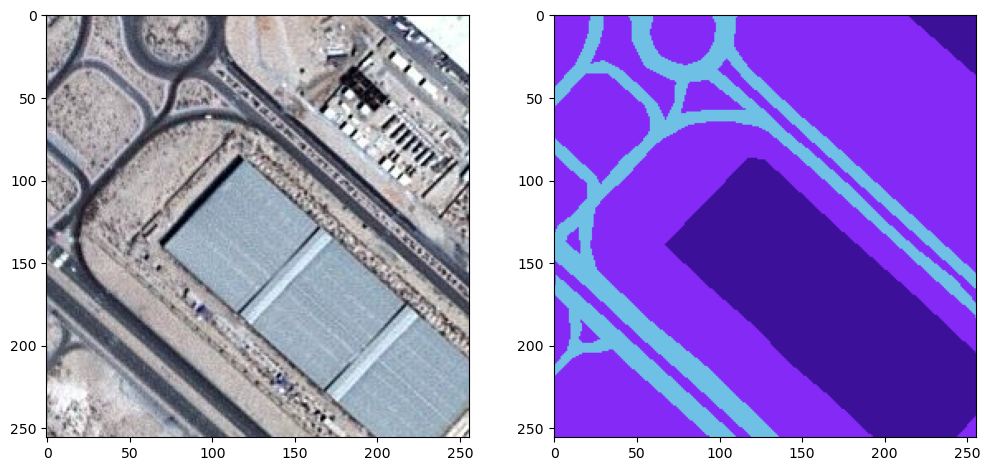

In [8]:
# Sanity check, view a few images
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [9]:
# Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  # 3C with base 16. Should return 60. 
print(a)
# Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

60


In [10]:
# Now replace RGB to integer values to be used as labels.
# Find pixels with combination of RGB for the above defined arrays...
# if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

Unique labels in label dataset are:  [0 1 2 3 4 5]


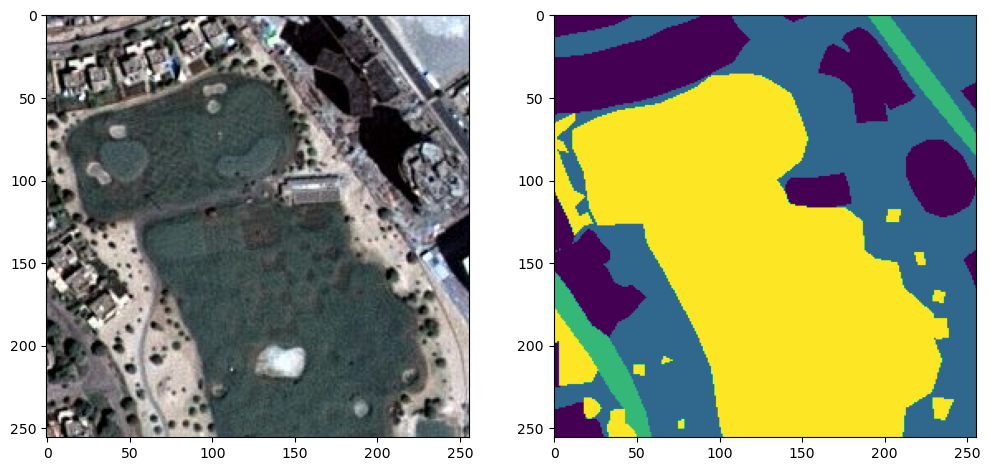

In [11]:
print("Unique labels in label dataset are: ", np.unique(labels))

# Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [12]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [13]:
# Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')), 
#                               np.ravel(labels,order='C'))
# print(weights)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow.keras
import tensorflow as tf

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=tensorflow.keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [17]:
'''
from tensorflow.keras.applications.resnet import ResNet50

IMAGE_SIZE = 256 # Assume square
NUM_CLASSES = 6

def DeeplabV3Plus(image_size, num_classes):
    model_input = tensorflow.keras.Input(shape=(image_size, image_size, 3))
    resnet50 = ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return tensorflow.keras.Model(inputs=model_input, outputs=model_output)

model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()
'''
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50

IMAGE_SIZE = 256  # Assume square
NUM_CLASSES = 6

def convolution_block(block_input, num_filters=32, kernel_size=3, padding='same', use_bias=False, dilation_rate=1):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        padding=padding,
        use_bias=use_bias,
        dilation_rate=dilation_rate,
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[1], dims[2]))(dspp_input)
    x = convolution_block(x, num_filters=128, kernel_size=1, use_bias=True)
    
    out_pool = layers.UpSampling2D(size=(dims[1] // x.shape[1], dims[2] // x.shape[2]), interpolation="bilinear")(x)
    
    out_1 = convolution_block(dspp_input, num_filters=128, kernel_size=1, dilation_rate=1)
    out_2 = convolution_block(dspp_input, num_filters=128, kernel_size=3, dilation_rate=2)
    out_3 = convolution_block(dspp_input, num_filters=128, kernel_size=3, dilation_rate=4)
    
    out_1 = layers.UpSampling2D(size=(dims[1] // out_1.shape[1], dims[2] // out_1.shape[2]), interpolation="bilinear")(out_1)
    out_2 = layers.UpSampling2D(size=(dims[1] // out_2.shape[1], dims[2] // out_2.shape[2]), interpolation="bilinear")(out_2)
    out_3 = layers.UpSampling2D(size=(dims[1] // out_3.shape[1], dims[2] // out_3.shape[2]), interpolation="bilinear")(out_3)
    
    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_2, out_3])
    return convolution_block(x, num_filters=128, kernel_size=1)

def DeeplabV3Plus(image_size, num_classes):
    model_input = layers.Input(shape=(image_size, image_size, 3))
    resnet50 = ResNet50(weights="imagenet", include_top=False, input_tensor=model_input)
    
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    
    return tf.keras.Model(inputs=model_input, outputs=model_output)

model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 9,109,126 (34.75 MB)

 Trainable params: 9,079,078 (34.63 MB)

 Non-trainable params: 30,048 (117.38 KB)

Epoch 1/100
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.6205 - jacard_coef: -0.9419 - loss: 1.1391
Epoch 1: saving model to ./weights\weights.04-deeplabv3.001.weights.h5
261/261 ━━━━━━━━━━━━━━━━━━━━ 122s 377ms/step - accuracy: 0.6208 - jacard_coef: -0.9425 - loss: 1.1383 - val_accuracy: 0.5364 - val_jacard_coef: -0.4497 - val_loss: 2.2894
Epoch 2/100
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.7664 - jacard_coef: -0.7201 - loss: 0.7005
Epoch 2: saving model to ./weights\weights.04-deeplabv3.002.weights.h5
261/261 ━━━━━━━━━━━━━━━━━━━━ 100s 383ms/step - accuracy: 0.7664 - jacard_coef: -0.7199 - loss: 0.7005 - val_accuracy: 0.5319 - val_jacard_coef: 0.1660 - val_loss: 18.0893
Epoch 3/100
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7828 - jacard_coef: -0.5875 - loss: 0.6404
Epoch 3: saving model to ./weights\weights.04-deeplabv3.003.weights.h5
261/261 ━━━━━━━━━━━━━━━━━━━━ 103s 396ms/step - accuracy: 0.7828 - jacard_coef: -0.5874 - loss: 0.6403 - val_a

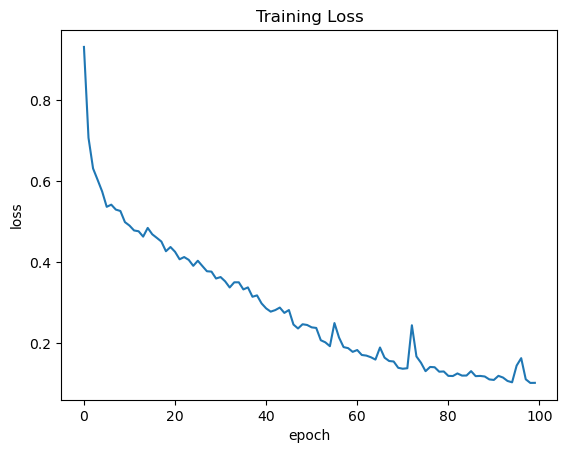

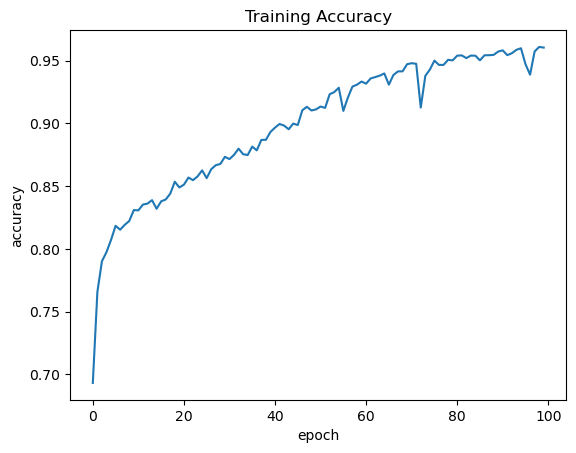

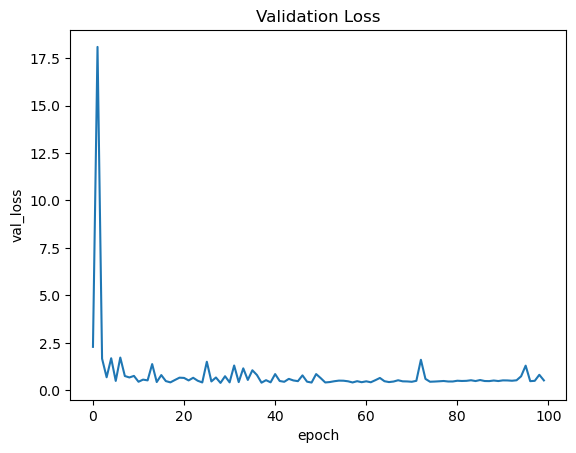

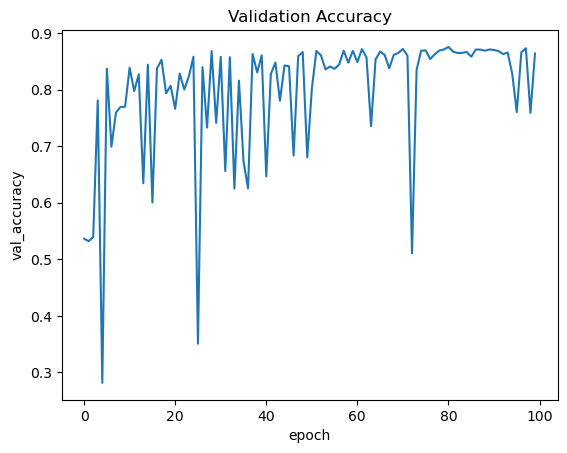

In [19]:
'''
sm.set_framework('tf.keras')
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

print(X_train_prepr.shape)
print(y_train.shape)

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

callbacks = [
             tensorflow.keras.callbacks.ModelCheckpoint(
                os.path.join("./weights", "weights.04-deeplabv3.{epoch:03d}.hdf5"), 
                save_best_only=False,
                save_weights_only=True,
                verbose=1
              ),
            ]

loss = tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy", jacard_coef]
)

history = model.fit(X_train_prepr, 
          y_train,
          batch_size=4, 
          epochs=100,
          validation_data=(X_test_prepr, y_test),
          verbose=1,
      callbacks=callbacks        )

model.save('./models/unet_with_deeplabv3+_backbone_100epochs.hdf5')

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()
'''
import os
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# Assuming you have your data preprocessed as X_train_prepr and y_train

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join("./weights", "weights.04-deeplabv3.{epoch:03d}.weights.h5"), 
        save_best_only=False,
        save_weights_only=True,
        verbose=1
    ),
]

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy", jacard_coef]
)

history = model.fit(
    X_train_prepr, 
    y_train,
    batch_size=4, 
    epochs=100,
    validation_data=(X_test_prepr, y_test),
    verbose=1,
    callbacks=callbacks
)

model.save('./models/unet_with_deeplabv3+_backbone_100epochs.hdf5')

# Plotting training and validation metrics
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()


In [20]:
from tensorflow.keras.models import load_model

# model = load_model("./models/standard_unet_100epochs.hdf5",
#                    custom_objects={'dice_loss_plus_2focal_loss': total_loss(),
#                                    'jacard_coef':jacard_coef()})

model = load_model("./models/unet_with_deeplabv3+_backbone_100epochs.hdf5", compile=False)

# IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


# Using built in keras function for IoU
from tensorflow.keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 672ms/step
Mean IoU = 0.6055543


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


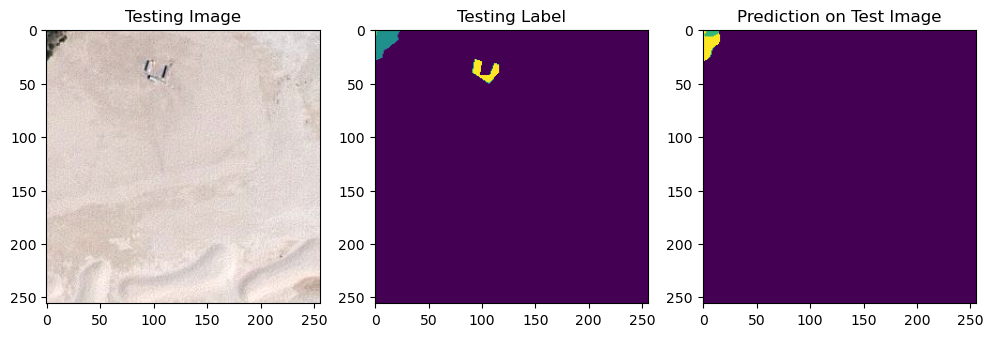

In [21]:
# Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
# test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(predicted_img)
plt.show()

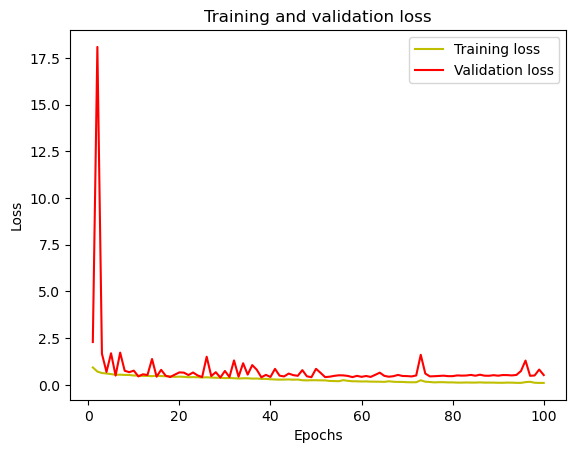

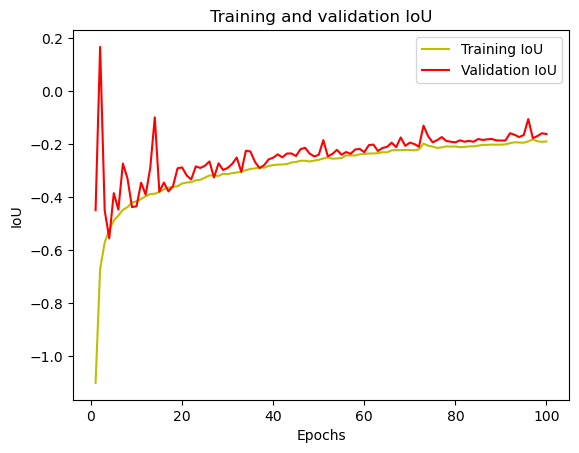

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()